# Predicting Stock Prices with continuous input using Long Short Term Memory Networks

---

## Introduction

---

They are networks with loops in them, allowing information to persist.
In the above diagram, a chunk of neural network, A, looks at some input xt and outputs a value ht. A loop allows information to be passed from one step of the network to the next.

![](RNN-rolled.png)

A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

![](RNN-unrolled.png)

---

# Importing Libraries

In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


## Importing data

The dataset is acquired from Yahoo Finance Database.

In [2]:
df = pd.read_csv("GOOG.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,311.449310,312.721039,310.103088,311.349976,311.349976,3937800
1,2010-01-05,311.563568,311.891449,308.761810,309.978882,309.978882,6048500
2,2010-01-06,310.907837,310.907837,301.220856,302.164703,302.164703,8009000
3,2010-01-07,302.731018,303.029083,294.410156,295.130463,295.130463,12912000
4,2010-01-08,294.087250,299.675903,292.651581,299.064880,299.064880,9509900


In [4]:
# since we don't need date and adj close, we can drop both the vector

In [21]:
newfram = df.drop(['Date','Adj Close'],axis=1)
newfram

,Open,High,Low,Close,Volume
0,311.449310,312.721039,310.103088,311.349976,3937800
1,311.563568,311.891449,308.761810,309.978882,6048500
2,310.907837,310.907837,301.220856,302.164703,8009000
3,302.731018,303.029083,294.410156,295.130463,12912000
4,294.087250,299.675903,292.651581,299.064880,9509900
5,300.276978,300.276978,295.100647,298.612823,14519600
6,296.893982,297.147339,292.100159,293.332153,9769600
7,286.382355,292.288940,285.095734,291.648102,13077600
8,290.063416,295.180145,289.521942,293.019196,8535300
9,294.752930,294.862213,287.152344,288.126007,10939600


## Preprocessing Data

---

In [16]:
def standard_scaler(X_train,X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test
    

### Split the data in train and test

In [17]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

---


# Building the LSTM Network

In [18]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [23]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(newfram[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1567, 20, 5)
y_train (1567,)
X_test (174, 20, 5)
y_test (174,)


In [24]:
model = build_model([X_train.shape[2], window, 100, 1])

/home/epsilon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/epsilon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=20, input_shape=(None, 5))`
  


Compilation Time :  0.04840970039367676


/home/epsilon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Training the network

In [27]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=10,
    validation_split=0.1,
    verbose=0)

In [28]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.59 MSE (0.77 RMSE)
Test Score: 1.04 MSE (1.02 RMSE)


## Visualizing predictions

In [29]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

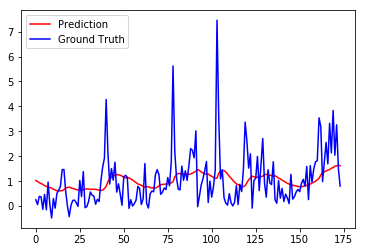

In [31]:
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()